In [1]:
import numpy as np
from jax.config import config

from stopro.data_generator.sin_1D import Sin1D
from stopro.data_generator.sin_1D_naive import Sin1DNaive
from stopro.data_preparer.data_preparer import DataPreparer

## Prepare data

In [2]:
project_name = "data"
simulation_name = "sin_1D_direct"
system_name = "sin_1D"
ly_num = 10
use_existing_params = False

In [3]:
## Initialize "DataPreparer", which is a class to generate data
data_preparer = DataPreparer(
    project_name,
    simulation_name,
    class_data_generator=Sin1D,
)

In [4]:
data_preparer.create_directory()

In [5]:
data_preparer.load_params(
    system_name=system_name, use_existing_params=use_existing_params
)

In [6]:
data_preparer.params_generate_training, data_preparer.params_generate_test

({'ly_num': 10, 'y_loc': 'both'}, {'test_num': 300})

In [7]:
#### Here, modify the parameters manually ###
data_preparer.params_generate_training["ly_num"] = ly_num
params_optimization = data_preparer.params_main["optimization"]
params_optimization["maxiter_GD"] = 1600
params_model = data_preparer.params_main["model"]
data_preparer.params_main["optimization"]["maxiter_scipy"] = [0]
data_preparer.params_main["optimization"]["print_process"] = False
#############################################
## Then update params
data_preparer.update_params()

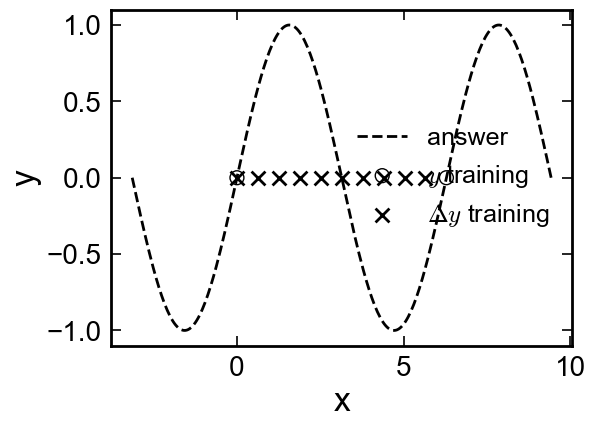

In [9]:
## generate data
r_train, f_train, r_test, f_test = data_preparer.make_data(
    show_train_plot=True,
    show_test_plot=False,
    save_data=True,
    save_train_plot=False,
    save_test_plot=False,
    return_data=True,
)

In [8]:
## save data
data_preparer.save_params_prepare()
data_preparer.save_params_main()
data_preparer.save_lbls()

## Run simulation

In [9]:
import time
from pathlib import Path

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config

from stopro.analyzer.analysis import analyze_result
from stopro.analyzer.make_each_plot import *
from stopro.analyzer.plot_sin_1D_each import plot_each_sin1D
from stopro.analyzer.plot_sinusoidal import plot_each_sinusoidal
from stopro.data_handler.data_handle_module import *
from stopro.GP.gp_1D_laplacian import GPmodel1DLaplacian
from stopro.GP.kernels import define_kernel
from stopro.solver.optimizers import optimize_by_adam
from stopro.sub_modules.init_modules import get_init, reshape_init
from stopro.sub_modules.load_modules import load_data, load_params
from stopro.sub_modules.loss_modules import hessian, logposterior

In [10]:
data_path = Path("data/sin_1D_direct")

In [11]:
# load params
params_main, params_prepare, lbls = load_params(data_path / "data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

In [12]:
# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)
if params_model["kernel_type"] == "sm":
    init = reshape_init(init, params_kernel_arg)

In [13]:
# load data
hdf_operator = HdfOperator(data_path)
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])
del f_train
del μ_train

args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]

In [14]:
# setup model
Kernel = define_kernel(params_model)
gp_model = GPmodel1DLaplacian(Kernel=Kernel)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
gp_model.set_constants(*args_predict)

func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

In [15]:
## training (fluctuation of loss and norm of gradients are written in "run.out", real time)
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: 1.1445496082305908


In [16]:
## prediction
fs, Σs = predictor(opt, *args_predict)
# unpack values
f_infer = [f for f in fs]
std = [jnp.sqrt(jnp.diag(Σ)) for Σ in Σs]

In [17]:
# save results
hdf_operator.save_record(lbls["record"], [theta, loss, norm_of_grads_list])
hdf_operator.save_infer_data(lbls["infer"], vnames["infer"], [f_infer, std])

In [18]:
# analysis
_, f_test = hdf_operator.load_test_data(lbls["test"], vnames["test"])
vals_list_analysis = analyze_result(
    f_test,
    f_infer,
    std,
    theta,
    loss,
    norm_of_grads_list,
    params_kernel_arg,
    vnames["analysis"],
    analysis_text_path=data_path / "data_output/analysis.txt",
)
hdf_operator.save_analysis_data(
    lbls["analysis"], vnames["analysis"], vals_list_analysis
)

[0.905177   0.92194396]


## Plot

In [19]:
from stopro.analyzer.plot_sin_1D_each import plot_each_sin1D

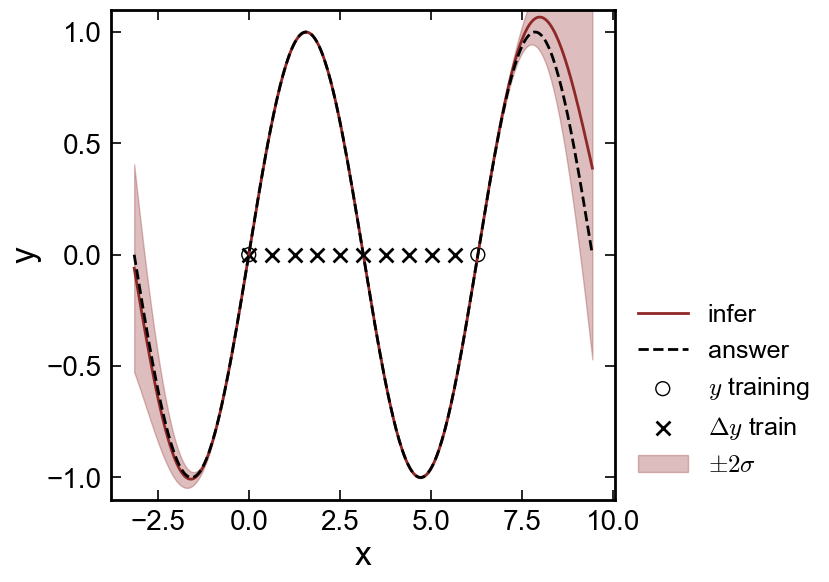

In [29]:
r_train, f_train = hdf_operator.load_train_data(lbls["train"], vnames["train"])
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(r_test[0], f_infer[0], label="infer", linestyle="-", color=COLOR["dark"])
# plot test data
ax.plot(r_test[0], f_test[0], label="answer", linestyle="--", color="k")
ax.scatter(
    r_train[0],
    f_train[0],
    label=r"$y$ training",
    marker="o",
    color="k",
    facecolor="None",
)
index_ly = 1
if len(r_train) == 3:
    ax.scatter(
        r_train[1], f_train[1], label="pbc", marker="+", color="k", s=140
    )
    index_ly = 2
if len(r_train) >= 2:
    ax.scatter(
        r_train[index_ly],
        np.zeros(len(r_train[index_ly])),
        label=r"$\Delta y$ train",
        marker="x",
        color="k",
    )
ax.fill_between(
    r_test[0],
    f_infer[0] - 2 * std[0],
    f_infer[0] + 2 * std[0],
    color=COLOR["dark"],
    alpha=0.3,
    label=r"$\pm 2\sigma$",
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(-1.1, 1.1)
ax.legend(loc="lower left", bbox_to_anchor=(1., 0.))
plt.show()
plt.clf()
plt.close()


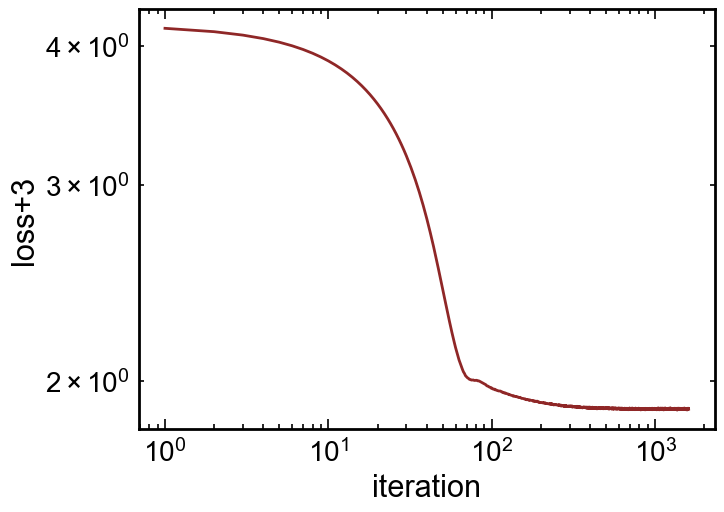

In [30]:
itr_step = 1
loss = hdf_operator.load_record("fun")
loss = loss[1:]  # Nelder-Meadによる最適化分を除外してプロット
loss_index = np.arange(len(loss)) * itr_step
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
clr = COLOR["dark"]
lbl = "loss"
# ax.plot(range(5,100,5),np.array(loss),color=clr,label=lbl)
ax.loglog(loss_index + 1, np.array(loss) + 3, color=clr)
ax.set_ylabel("loss+3", fontsize=22)
ax.set_xlabel("iteration", fontsize=22)
plt.show()
plt.clf()
plt.close()
